In [1]:
# example python script for loading spikefinder data
#
# for more info see https://github.com/codeneuro/spikefinder
#
# requires numpy, pandas, matplotlib
#
# each dataset has 10-20 recordings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_dir = 'data/train/'
datasets = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
calcium_trains = {}
spikes_trains = {}
for dataset in datasets:
    calcium_trains[dataset] = pd.read_csv(train_dir + dataset + '.train.calcium.csv')
    spikes_trains[dataset] = pd.read_csv(train_dir + dataset + '.train.spikes.csv')

#necessary because some runs have nans in them
def true_len(train):
    nans = np.isnan(train)
    if np.sum(nans) == 0:
        return len(train)
    else:
        return np.argmax(nans)

def plot(calcium, spikes, panel):
  x = np.arange(len(calcium)) / 100.0
  plt.figure(figsize=(15, 3))
  plt.plot(x, calcium, color=(.1, .6, .4))
  plt.plot(x, spikes / 2.0 - 1, color='k')
  plt.yticks([])
  plt.ylim([-2., 4.])
  plt.xlim(panel)
  plt.grid()
  plt.show()

def plot_exp(dataset, run, panel):
    d = str(dataset)
    r = str(run)
    plot(calcium_trains[d][r], spikes_trains[d][r], panel)

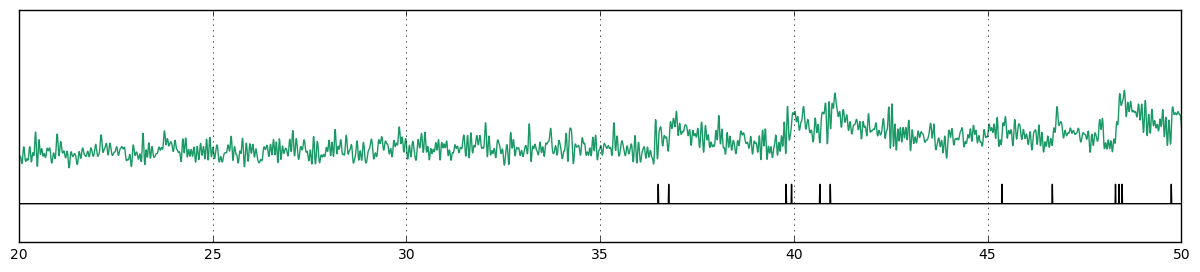

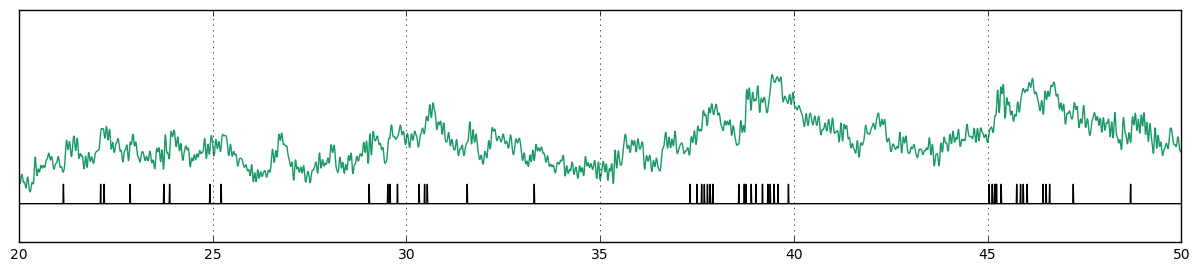

In [2]:
plot_exp(10,1,[20,50])
plot_exp(10,2,[20,50])

In [3]:
def ts_to_windows(ts, window_width, indices=[]):
    if len(indices) == 0:
        indices = range(len(ts) - window_width+1)
    return np.vstack( ts[i:i+window_width] for i in indices)

In [4]:
#takes in prediction function 
def run_model(predict, series, window_width, offset):
    n = len(series)
    nanfree_series = series[~np.isnan(series)]
    predictions = predict(ts_to_windows(nanfree_series, window_width))
    return np.concatenate(([np.nan] * (offset), predictions, [np.nan] * (n - len(predictions) - offset)))

In [5]:
from evaluate import score
def score2(x, y, method):
    return score({'1': x}, {'1': y}, method)

In [6]:
def frame_to_dict(df):
    d = {}
    for i in df:
        d[i] = df[i].values
    return d

In [7]:
def score_spikes(dataset, pred, window_width, offset, runs = None):
    if runs == None:
        runs = list(calcium_trains[dataset])
    predicted_spikes = {}
    for run in runs:
        predicted_spikes[run] = run_model(pred, calcium_trains[dataset][run], window_width, offset)
    scores = score(predicted_spikes,frame_to_dict(spikes_trains[dataset]), method='corr')
    return np.median(scores)

## Train logit model

In [8]:
def run_to_windows(ct, st, exclusion_radius, window_width, offset):
    n = true_len(st)
    
    #locations of spikes
    spike_indices = np.nonzero(st)[0]
    
    #neighborhood of spikes
    spike_nbhds = np.convolve(np.ones(2*exclusion_radius + 1),st,'same')
    nospike_indices = np.nonzero(spike_nbhds == 0)[0]
    
    #trim so they have a window around them
    spike_indices = spike_indices[(spike_indices > offset) * (spike_indices < n - window_width + offset)]
    nospike_indices = nospike_indices[(nospike_indices > offset) * (nospike_indices < n - window_width + offset)]
        
    X_spike = ts_to_windows(ct, window_width, spike_indices - offset)
    X_nospike = ts_to_windows(ct, window_width, nospike_indices - offset)

    X = np.concatenate((X_spike, X_nospike))
    y = np.concatenate((np.ones(X_spike.shape[0]),np.zeros(X_nospike.shape[0])))
    
    return (X,y)

In [9]:
def make_training(dataset, window_width, offset, exclusion_radius):
    runs = list(calcium_trains[dataset])
    np.random.shuffle(runs)
    validations = len(runs)/4

    X_train = np.empty( shape=(0, window_width) )
    y_train = np.empty( shape= (0))

    X_valid = np.empty( shape=(0, window_width) )
    y_valid = np.empty( shape= (0))

    for run in runs[0:-validations]:
        (X, y) = run_to_windows(calcium_trains[dataset][run], spikes_trains[dataset][run], exclusion_radius, window_width, offset)

        X_train = np.concatenate((X_train, X))
        y_train = np.concatenate((y_train, y))

    for run in runs[-validations:]:
        (X, y) = run_to_windows(calcium_trains[dataset][run], spikes_trains[dataset][run], exclusion_radius, window_width, offset)

        X_valid = np.concatenate((X_valid, X))
        y_valid = np.concatenate((y_valid, y))
    
    validation_runs = runs[-validations:]
    
    return X_train, y_train, X_valid, y_valid, validation_runs

In [10]:
from sklearn import linear_model

In [11]:
def balanced_train(X_train,y_train):
    n_spikes = int(np.sum(y_train))
    nonspike_indices = np.nonzero(y_train == 0)[0]
    spike_indices = np.nonzero(y_train)[0]

    balanced_nonspike_indices = np.random.choice(nonspike_indices,n_spikes)
    balanced_indices = np.concatenate((spike_indices, balanced_nonspike_indices))
    np.random.shuffle(balanced_indices)

    X_balanced = X_train[balanced_indices,:]
    y_balanced = y_train[balanced_indices]
    
    return X_balanced, y_balanced

In [12]:
def boosted_logistic(X_train, y_train):
   
    X_balanced, y_balanced = balanced_train(X_train,y_train)
    logit = linear_model.LogisticRegression()

    logit.fit(X_balanced, y_balanced)
    print "Training score for L2: ", logit.score(X_balanced, y_balanced)
    L2_predictions = logit.predict(X_train)
    
    logit2 = linear_model.LogisticRegression()
    logit2.fit(X_train[L2_predictions > 0], y_train[L2_predictions > 0])
    print "Training score for L3: ", logit2.score(X_train[L2_predictions > 0], y_train[L2_predictions > 0])
   
    return logit, logit2

In [13]:
def acc_score(X,y,pred):
    y_predicted = pred(X)
    y_binary = np.round(y_predicted)
    errors = np.sum(y - y_binary != 0)
    return 1 - float(errors)/len(y)

In [14]:
dataset = '1'

window_width = 401
offset = 100
exclusion_radius = 2

X_train, y_train, X_valid, y_valid, validation_runs = make_training(dataset, window_width, offset, exclusion_radius)
logit, logit2 = boosted_logistic(X_train, y_train)
pred2 = lambda x: logit2.predict_proba(x)[:,1]*logit.predict(x)

Training score for L2:  0.840572926418
Training score for L3:  0.912381804375


In [15]:
print "Validation score for L3: ", acc_score(X_valid, y_valid, pred2)

Validation score for L3:  0.986144013228


In [16]:
print "correlation score across all runs: ", score_spikes(dataset, pred2, window_width, offset)

correlation score across all runs:  0.519732702737


In [17]:
print "correlation score on just validation/test runs: ", score_spikes(dataset, pred2, window_width, offset, validation_runs)

correlation score on just validation runs:  0.442979516421
